In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df=pd.read_csv("SensorTH-Room 256.csv")

In [6]:
df.drop("Date",axis=1,inplace=True)

In [7]:
df.head()

,Humidity,Temperature,Date (new)
0,64.83,69.5,1/15/2020 1:49
1,63.77,70.2,1/15/2020 3:49
2,62.67,71.3,1/15/2020 5:49
3,68.40,67.0,1/15/2020 7:49
4,67.84,66.9,1/15/2020 9:49


In [8]:
df['Date (new)'] = pd.to_datetime(df['Date (new)'])
df = df.set_index('Date (new)')

In [9]:
df.head()

,Humidity,Temperature
Date (new),,
2020-01-15 01:49:00,64.83,69.5
2020-01-15 03:49:00,63.77,70.2
2020-01-15 05:49:00,62.67,71.3
2020-01-15 07:49:00,68.40,67.0
2020-01-15 09:49:00,67.84,66.9


In [10]:
df.dropna(inplace=True)

In [11]:
df[df['Temperature']<1]

,Humidity,Temperature
Date (new),,
2020-01-19 07:49:00,63.0,0.9
2020-02-07 17:49:00,43.0,0.3
2020-02-09 05:49:00,50.0,0.8


In [12]:
df.loc['1/19/2020 7:49']['Temperature']=(df.loc['1/19/2020 5:49']['Temperature']+df.loc['1/19/2020 9:49']['Temperature'])/2

In [13]:
df.loc['2/7/2020 17:49']['Temperature']=(df.loc['2/7/2020 15:49']['Temperature']+df.loc['2/7/2020 19:49']['Temperature'])/2

In [14]:
df.loc['2/9/2020 5:49']['Temperature']=(df.loc['2/9/2020 3:49']['Temperature']+df.loc['2/9/2020 7:49']['Temperature'])/2

In [15]:
df[df['Temperature']<1]

,Humidity,Temperature
Date (new),,


In [43]:
ts=df.loc['1/20/2020':'2/02/2020']['Temperature']
#ts=pd.concat([df.loc['1/20/2020':'1/24/2020'],df.loc['1/27/2020':'1/31/2020']])['Temperature']
ts.tail()

Date (new)
2020-02-02 15:49:00    69.8
2020-02-02 17:49:00    70.5
2020-02-02 19:49:00    70.8
2020-02-02 21:49:00    70.1
2020-02-02 23:49:00    70.8
Name: Temperature, dtype: float64

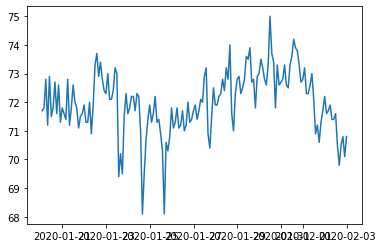

In [44]:
plt.plot(ts)

In [45]:
ts=pd.DataFrame(ts)
ts.head()

,Temperature
Date (new),
2020-01-20 01:49:00,71.7
2020-01-20 03:49:00,71.8
2020-01-20 05:49:00,72.8
2020-01-20 07:49:00,71.2
2020-01-20 09:49:00,72.9


In [46]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2020-01-20 01:49:00 to 2020-02-02 23:49:00
Data columns (total 1 columns):
Temperature    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [47]:
nobs = 84
ts_train, ts_test = ts[0:-nobs], ts[-nobs:]

# Check size
print(ts_train.shape) 
print(ts_test.shape)  

(84, 1)
(84, 1)


In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(ts_train)
scaled_train_data = scaler.transform(ts_train)
scaled_test_data = scaler.transform(ts_test)

In [49]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [59]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [60]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
72/72 [==============================] - 1s 8ms/step - loss: 0.0694
Epoch 2/20
72/72 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 3/20
72/72 [==============================] - 0s 5ms/step - loss: 0.0330
Epoch 4/20
72/72 [==============================] - 0s 5ms/step - loss: 0.0334
Epoch 5/20
72/72 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 6/20
72/72 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 7/20
72/72 [==============================] - 0s 5ms/step - loss: 0.0323
Epoch 8/20
72/72 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 9/20
72/72 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 10/20
72/72 [==============================] - 0s 5ms/step - loss: 0.0321
Epoch 11/20
72/72 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 12/20
72/72 [==============================] - 0s 5ms/step - loss: 0.0325
Epoch 13/20
72/72 [==============================

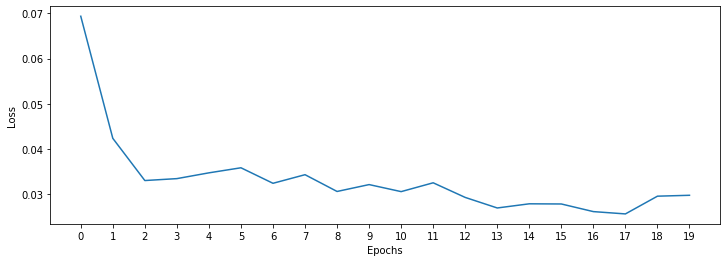

In [61]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm)

In [62]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(ts_test)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [63]:
lstm_predictions_scaled

[array([0.62464625], dtype=float32),
 array([0.6222626], dtype=float32),
 array([0.62152946], dtype=float32),
 array([0.6196802], dtype=float32),
 array([0.6187569], dtype=float32),
 array([0.62037355], dtype=float32),
 array([0.62050647], dtype=float32),
 array([0.6222489], dtype=float32),
 array([0.6243471], dtype=float32),
 array([0.6233376], dtype=float32),
 array([0.6247636], dtype=float32),
 array([0.6262297], dtype=float32),
 array([0.6260969], dtype=float32),
 array([0.6260132], dtype=float32),
 array([0.6259162], dtype=float32),
 array([0.6258638], dtype=float32),
 array([0.62588245], dtype=float32),
 array([0.6260117], dtype=float32),
 array([0.62618953], dtype=float32),
 array([0.62635434], dtype=float32),
 array([0.62651294], dtype=float32),
 array([0.6266429], dtype=float32),
 array([0.6267857], dtype=float32),
 array([0.62688285], dtype=float32),
 array([0.62691694], dtype=float32),
 array([0.62693137], dtype=float32),
 array([0.6269389], dtype=float32),
 array([0.626949]

In [64]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[71.59801898],
       [71.58467054],
       [71.58056498],
       [71.57020926],
       [71.56503859],
       [71.57409186],
       [71.57483621],
       [71.58459377],
       [71.59634371],
       [71.59069071],
       [71.5986762 ],
       [71.60688634],
       [71.60614266],
       [71.60567403],
       [71.60513062],
       [71.60483723],
       [71.6049417 ],
       [71.60566568],
       [71.60666137],
       [71.60758429],
       [71.60847249],
       [71.60920014],
       [71.6099999 ],
       [71.61054397],
       [71.61073489],
       [71.61081567],
       [71.61085773],
       [71.61091447],
       [71.61101027],
       [71.61114345],
       [71.61129365],
       [71.61144285],
       [71.61158738],
       [71.61171622],
       [71.6118207 ],
       [71.6118928 ],
       [71.61193819],
       [71.61196723],
       [71.61199026],
       [71.61201196],
       [71.61203566],
       [71.61206102],
       [71.61208773],
       [71.61211276],
       [71.61213646],
       [71

In [65]:
ts_test['LSTM_Predictions'] = lstm_predictions
ts_test

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Temperature,LSTM_Predictions
Date (new),,
2020-01-27 01:49:00,71.9,71.598019
2020-01-27 03:49:00,71.4,71.584671
2020-01-27 05:49:00,71.7,71.580565
2020-01-27 07:49:00,72.1,71.570209
2020-01-27 09:49:00,72.0,71.565039
2020-01-27 11:49:00,72.9,71.574092
2020-01-27 13:49:00,73.2,71.574836
2020-01-27 15:49:00,70.9,71.584594
2020-01-27 17:49:00,70.4,71.596344


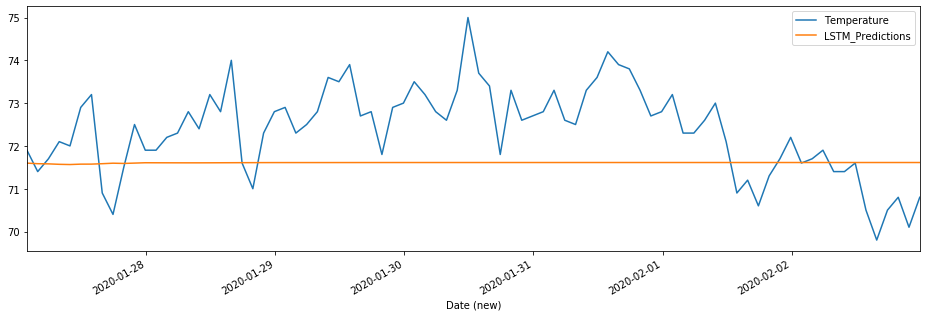

In [66]:
ts_test['Temperature'].plot(figsize = (16,5), legend=True)
ts_test['LSTM_Predictions'].plot(legend = True)